In [2]:
from src.load import read_data
import numpy as np
import pandas as pd
import pickle
from src.kir_transformers import cv
from src.kir_models import lr
from src.kir_transformers import tfidf_new
from src.kir_models import metrics
from src.kir_models import featureEngineering
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

In [3]:
# loaded load.py
train_X, val_X, train_y, val_y = read_data()

In [4]:
# train_y.head(5)

In [5]:
# train_X.head(10)

In [6]:
# fill up empty reviews

train_X['review'].fillna('', inplace=True)
val_X['review'].fillna('', inplace=True)

In [6]:
# loading kir_transformers.py for count vectorizer
# using only the review column for now 
params = {'max_features': 1000}
vectorizer = cv(train_X['review'], params)

In [8]:
# loading kir_transformers.py for tfidf vectorizer
params = {'max_features': 1000}
tf_vectorizer = tfidf_new(train_X['review'], params)

In [7]:
# tranform both train and val - CV
train_vec = vectorizer.transform(train_X['review'])
val_vec = vectorizer.transform(val_X['review'])

In [9]:
# tranform both train and val - TFIDF
train_vec = tf_vectorizer.transform(train_X['review'])
val_vec = tf_vectorizer.transform(val_X['review'])

In [10]:
train_vec_df = pd.DataFrame.sparse.from_spmatrix(train_vec)
val_vec_df = pd.DataFrame.sparse.from_spmatrix(val_vec)

In [11]:
# addition of columns for Stephen's function
train_vec_df['date'] = train_X['date']
val_vec_df['date'] = val_X['date']

train_vec_df['user_id'] = train_X['user_id']
val_vec_df['user_id'] = val_X['user_id']

train_vec_df['rating'] = train_X['rating']
val_vec_df['rating'] = val_X['rating']

In [13]:
# pass through the new function defined by Stephen and drop columns that can't be fed to the LR model
train_vec_new, fake_users = featureEngineering(train_vec_df, train_y)
train_vec_new.drop(['date', 'user_id', 'rating'], inplace=True, axis =1)
val_vec_new, fake_users = featureEngineering(val_vec_df, val_y, fake_users)
val_vec_new.drop(['date', 'user_id', 'rating'], inplace=True, axis =1)

In [ ]:
train_vec_new.head(5)

In [8]:
# # reviews that are fake will either have a very high rating or a very low rating
# train_vec_df['rating_5'] = (train_X['rating']==5).astype(int)
# val_vec_df['rating_5'] = (val_X['rating']==5).astype(int)
# train_vec_df['rating_1'] = (train_X['rating']==1).astype(int)
# val_vec_df['rating_1'] = (val_X['rating']==1).astype(int)

# # taking all the fake users as a separate column (anyone who has ever written a fake review)
# fake_users = train_X[train_y['label']==1]['user_id'].unique()
# non_fake_users = np.setdiff1d(train_X[train_y['label']==0]['user_id'].unique(), train_X[train_y['label']==1]['user_id'].unique())
# train_vec_df['no_fake'] = train_X['user_id'].isin(non_fake_users).astype(int)
# val_vec_df['no_fake'] = val_X['user_id'].isin(non_fake_users).astype(int)
# train_vec_df['fake'] = train_X['user_id'].isin(fake_users).astype(int)
# val_vec_df['fake'] = val_X['user_id'].isin(fake_users).astype(int)

In [9]:
train_vec_df.shape

(250874, 1004)

In [11]:
def oversampler(train_X, train_y, minority):
    minor = train_X[train_y['label']==minority]
    major = train_X[train_y['label']!=minority]
    n = major.shape[0] - minor.shape[0] # explain this
    os = minor.sample(n,replace=True,random_state=42)
    l = pd.DataFrame(np.ones(n), columns=['label'])
    
    return pd.concat([train_X,os],axis=0), pd.concat([train_y, l], axis=0)


In [12]:
# train_X_os, train_y_os = oversampler(train_vec_df, train_y, 1)

In [14]:
# train_y_os['label'].value_counts()

0.0    225055
1.0    225055
Name: label, dtype: int64

In [ ]:
# loading kir_models.py for logistic regression

# LR parameter 
params = {'C':[10**-1, 1, 10, 100, 10**3], 'penalty': ['l1', 'l2']}
lr_grid = LogisticRegression(random_state=0, solver = 'liblinear')
# CV - 5 fold 
clf = GridSearchCV(lr, params, cv = 3, scoring = 'roc_auc', verbose=10) # scoring = average_precision
clf.fit(train_vec_df, train_y['label'])

In [ ]:
gs_results = pd.DataFrame(clf.cv_results_)

In [ ]:
gs_results

In [20]:
# fit the best hyperparameter configuration to LR - CV

p_best = {'C':100, 'penalty': 'l2', 'verbose':10, 'solver':'liblinear'}
model = lr(p_best)
# model.fit(train_vec_df, train_y['label'])
model.fit(train_vec_new, train_y['label'])

[LibLinear]

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=10, warm_start=False)

In [14]:
# fit the best hyperparameter configuration to LR - TFIDF

p_best_tf = {'C':0.1, 'penalty': 'l2', 'verbose':10, 'solver':'liblinear'}
model = lr(p_best_tf)
# model.fit(train_vec_df, train_y['label'])
model.fit(train_vec_new, train_y['label'])

[LibLinear]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=10, warm_start=False)

Predicted      0     1    All
True                         
0          31808  2472  34280
1            462  1176   1638
All        32270  3648  35918


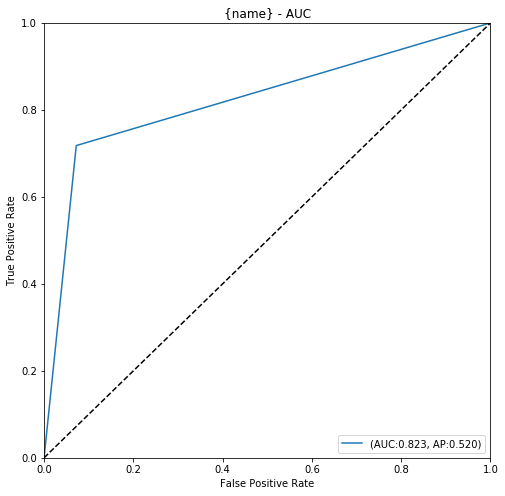

In [16]:
# hyperparameter tuning - no oversampling - CV
metrics(model, val_vec_df, val_y['label'], 'logisticReg')

Predicted      0     1    All
True                         
0.0        31272  2306  33578
1.0          998  1342   2340
All        32270  3648  35918


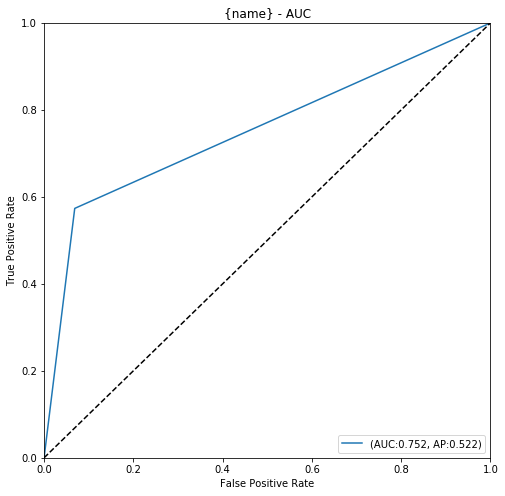

In [18]:
# using oversampling - CV
metrics(model, val_vec_df, val_y['label'], 'logisticReg')

Predicted      0     1    All
True                         
0          32014  2527  34541
1            256  1121   1377
All        32270  3648  35918


NameError: name 'load' is not defined

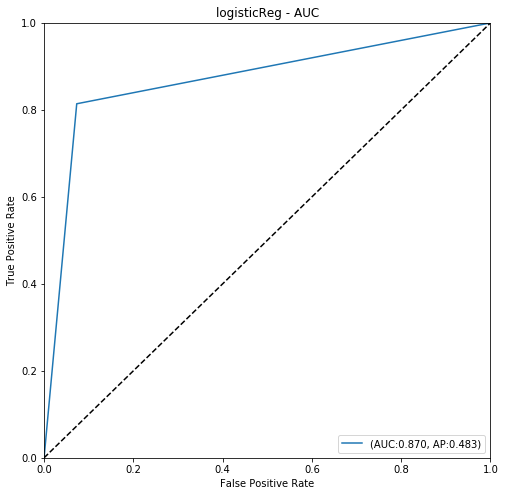

In [21]:
# using feature Engg by Stephen - CV
metrics(model, val_vec_new, val_y['label'], 'logisticReg')

In [ ]:
# using feature Engg by Stephen - TFIDF
metrics(model, val_vec_new, val_y['label'], 'logisticReg')

Predicted      0     1    All
True                         
0          32024  2140  34164
1            246  1508   1754
All        32270  3648  35918


NameError: name 'load' is not defined